<a href="https://colab.research.google.com/github/daeone/deep-learning-with-python-notebooks/blob/master/A2_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Download data

In [1]:
import numpy as np
import scipy as sp
import scipy.special as spsp
import matplotlib.pyplot as plt

# Fetch MNIST dataset
from sklearn.datasets import fetch_openml
mnist_data = fetch_openml('mnist_784')
mnist_data_x = (mnist_data['data']+0.5)/256.0
mnist_data_y = mnist_data['target'].astype('int8')

data_dim = mnist_data_x.shape[1]

## Split data into training and validation

In [2]:
def display_mnist_digit(x,lbl=None):
  plt.imshow(x.reshape(28,28))
  plt.xticks([])
  plt.yticks([])
  if lbl is not None:
    plt.title(lbl)

def binary_mnist(c1,c0,N_train=200,N_val=200,seed=0):
  mask = np.logical_or(mnist_data_y == c1,mnist_data_y == c0)
  mnistbin_x = mnist_data_x[mask,:]
  mnistbin_y = mnist_data_y[mask] == c1 # label is true if digit is a 9, otherwise false

  if seed is not None:
    np.random.seed(seed)
  num_data = mnistbin_x.shape[0]
  rp = np.random.permutation(num_data)

  # Split the data into training and validation
  train_x = mnistbin_x[rp[:N_train]]
  train_y = mnistbin_y[rp[:N_train]]
  val_x = mnistbin_x[rp[N_train:(N_train+N_val)]]
  val_y = mnistbin_y[rp[N_train:(N_train+N_val)]]

  return train_x,train_y,val_x,val_y

mnistbin_train_x,mnistbin_train_y,mnistbin_val_x,mnistbin_val_y = binary_mnist(9,4)

# Step 1: Explore the data

**QUESTION**

49.0% of the training data is class True, corresponding to 98 data points


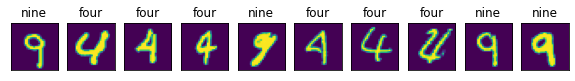

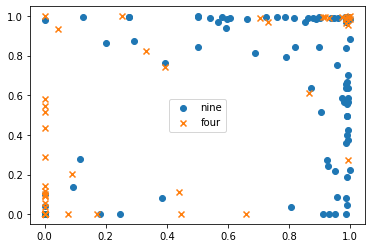

In [3]:
# Print statistics
print('{}% of the training data is class True, corresponding to {} data points'.format(100*np.sum(mnistbin_train_y)/len(mnistbin_train_y),np.sum(mnistbin_train_y)))

# Visualize a few images
np.random.seed(0)
num_digits = 10
plt.figure(figsize=(10,5))
for i in range(num_digits):
  ind = np.random.randint(0,mnistbin_train_x.shape[0])
  plt.subplot(1,num_digits,i+1)
  display_mnist_digit(mnistbin_train_x[ind,:],
                      'nine' if mnistbin_train_y[ind] else 'four')

# Construct a scatter plot of two arbitrary dimensions
vis_dims = (211,238)
plt.figure()
plt.scatter(mnistbin_train_x[mnistbin_train_y==True][:,vis_dims[0]],
            mnistbin_train_x[mnistbin_train_y==True][:,vis_dims[1]],
            marker='o', label='nine')
plt.scatter(mnistbin_train_x[mnistbin_train_y==False][:,vis_dims[0]],
            mnistbin_train_x[mnistbin_train_y==False][:,vis_dims[1]],
            marker='x', label='four')
plt.legend()



# Step 2: Implement Logistic Regression

## Implement the sigmoid and log-sigmoid functions
Here we implement the sigmoid function to test that things are working properly.

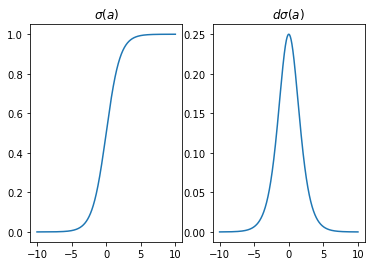

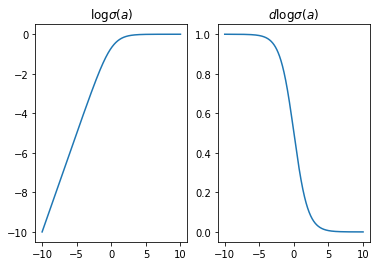

In [4]:
def sigmoid(a):
  # Implement the sigmoid function 1/(1+exp(-a)) and its derivative
  #
  # Input: a - Vector of values
  # Output: s,ds
  #   s - Vector of sigmoid function evaluated at the values in a
  #  ds - Vector of the derivatives of the sigmoid evaluated at the values of a
  #
  # TODO: Implement this function.  Your implementation should be not just be a 
  # call to np.exp() wrapped around your implementation of log_sigmoid().
  # Rather, you should expand and simplify the expressions of the sigmoid
  # function and it's derivatives.
  #
  # NOTE: you may only use basic exp/log functions from numpy here.  Only
  # np.exp, np.log, np.log1p, np.log1m, along with basic arithmetic are allowed
  # in your implementation.
  z = np.exp(-a)
  s = 1 / (1+z)
  ds = s * (1-s)

  return s, ds

def log_sigmoid(a):
  # Implement the log sigmoid function log(1/(1+exp(-a))) and its derivative
  #
  # Input: a - Vector of values
  # Output: logs,dlogs
  #   logs - Vector of log sigmoid function evaluated at the values in a
  #  dlogs - Vector of the derivatives of the logsigmoid evaluated at the values of a
  #
  # TODO: Implement this function.  Your implementation should be not just be a 
  # call to np.log() wrapped around your implementation of sigmoid().  Rather,
  # you should expand and simplify the expressions of the log sigmoid function
  # and it's derivatives.
  #
  # NOTE: you may only use basic exp/log functions from numpy here.  Only
  # np.exp, np.log, np.log1p, np.log1m, along with basic arithmetic are allowed
  # in your implementation.
  exp_positive = np.exp(a)
  logs_ep = np.log1p(exp_positive)
  logs = a - logs_ep
  dlogs  = 1/(1+exp_positive)
  
  return logs, dlogs

def test_sigmoid_impl():
  # These are sanity checks, not exhaustive unit tests.  These may pass but you
  # may still have bugs.  However, if these don't pass you almost certainly have
  # bugs.

  avals = [-5,0,1]
  for a in avals:
    sa, dsa = sigmoid(a)
    lsa, dlsa = log_sigmoid(a)

    # VERY IMPORTANT: spsp.expit() should only be used for testing here.  You 
    # are expected to implement the sigmoid and logsigmoid directly in terms of
    # the numpy functions mentioned above.
    assert np.abs(sa - spsp.expit(a)) < 1e-8
    assert np.abs(lsa - np.log(sa)) < 1e-8
    assert np.abs(dlsa - (1.0/sa)*dsa) < 1e-8

    eps = 1e-10
    dsa_fd = (sigmoid(a+eps)[0] - sigmoid(a-eps)[0])/(2*eps)
    dlsa_fd = (log_sigmoid(a+eps)[0] - log_sigmoid(a-eps)[0])/(2*eps)
    assert np.abs(dsa-dsa_fd) < 1e-6
    assert np.abs(dlsa-dlsa_fd) < 1e-6

  ina = np.linspace(-10,10,1000)
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(ina,sigmoid(ina)[0])
  plt.title('$\sigma(a)$')
  plt.subplot(1,2,2)
  plt.plot(ina,sigmoid(ina)[1])
  plt.title('$d \sigma(a)$')

  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(ina,log_sigmoid(ina)[0])
  plt.title('$\log \sigma(a)$')
  plt.subplot(1,2,2)
  plt.plot(ina,log_sigmoid(ina)[1])
  plt.title('$d \log \sigma(a)$')
  
test_sigmoid_impl()

## Implement logistic regression log probability and loss
Use the above sigmoid and log-sigmoid functions to implement logistic regression log probability and loss functions

In [5]:
def logregr_logprob(x,theta):
  # Compute the log probility of the input belonging to class 1 for a
  # logistic regression model with parameters theta
  #
  # Input:
  #       x - a NxD array of N training examples with dimension D
  #   theta - a (D+1)x1 array of parameters.  The first D are the weights of
  #           each input dimenion (w).  The last entry is the bias (b).
  #
  # Output: lp
  #     lp - an Nx2 vector of log likelihoods of class 0 and class 1 given x
  #
  # TODO: Implement this function.  You should use your implementations of
  # the sigmoid and log_sigmoid functions above.
  N = x.shape[0]
  D = x.shape[1]
  w = theta[:D]
  b = theta[-1:]
  a = np.matmul(x,w) + b
  lp = np.zeros((N,2))
  ls0 = log_sigmoid(-a)[0]
  ls1 = log_sigmoid(a)[0]
  lp[:,0] = ls0
  lp[:,1] = ls1

  return lp

def logregr_loss(x,y,theta,lmbda=0):
  # Compute the negative log likelihood of a set of training samples for a
  # logistic regression model with regularization parameter lambda
  #
  # Input:
  #       x - a NxD array of N training examples with dimension D
  #       y - a Nx1 array with true/false (1/0) labels for each training example
  #   theta - a (D+1)x1 array of parameters.  The first D are the weights of
  #           each input dimenion (w).  The last entry is the bias (b).
  #  lambda - a scalar indicating the strength of the regularization
  #
  # Output: loss, grad, acc
  #     loss - scalar,  negative log likelihood of training data
  #    grad - a (D+1)x1 vector with the gradient gradient of negative log
  #         - likelihood with respect to theta
  #     acc - scalar, accuracy of the currect value of theta on the data
  #           computed by counting what fraction of times the correct class is 
  #           given a probability > 0.5 (or log probability > log(0.5)).
  #
  # TODO: Implement this function.  You should use your implementations of
  # the sigmoid and log_sigmoid functions above.

  lp = logregr_logprob(x,theta)
  ls0 = lp[:,0]
  ls1 = lp[:,1]
  
  x_trans = np.transpose(x)
  D = x.shape[1]
  w = theta[:D]
  b = theta[-1:]
  a = np.matmul(x,w) + b
  s = sigmoid(a)[0]

  loss = -np.sum((1-y)*ls0 + y*ls1) + lmbda*np.dot(w,w)/2

  grad_w = lmbda * w - np.matmul(x_trans,(y-s))
  grad_b = -np.sum(y-s)
  grad = np.append(grad_w,grad_b)

  acc = np.sum(((1-y)*ls0 + y*ls1) > np.log(0.5)) / y.shape[0]
  return loss, grad, acc



def test_logregr_logprob():
  # These are sanity checks, not exhaustive unit tests.  These may pass but you
  # may still have bugs.  However, if these don't pass you almost certainly have
  # bugs.
  
  # Predicted probabilities in this case should be [0.5,0.5]
  assert np.all(np.abs(np.log(0.5) - logregr_logprob(np.zeros((1,1)), np.zeros((2)))) < 1e-8)
  # Predicted probabilities in this case should be approximately [0,1]
  assert np.all(np.abs(np.array([-100,0]) - logregr_logprob(np.zeros((1,1)), np.array([0,100]))[0]) < 1e-8)
  # Predicted probabilities in this case should be approximately [1,0]
  assert np.all(np.abs(np.array([0,-100]) - logregr_logprob(np.zeros((1,1)), np.array([0,-100]))[0]) < 1e-8)

  np.random.seed(0)
  test_N = 10
  test_D = 4
  test_x = np.random.randn(test_N,test_D)
  test_y = np.random.rand(test_N) > 0.5
  test_theta = np.concatenate((np.random.randn(test_D),np.random.randn(1)),axis=0)
  test_loss, test_dloss, _ = logregr_loss(test_x,test_y,test_theta)

  # loss should be negative sum of logprob
  lps = logregr_logprob(test_x,test_theta)
  assert np.abs(-np.sum((1-test_y)*lps[:,0] + test_y*lps[:,1]) - test_loss) < 1e-8
  
  # central difference approximation of the gradient should be fairly accurate
  test_loss, test_dloss, _ = logregr_loss(test_x,test_y,test_theta,lmbda=1)
  eps = 1e-8
  test_dloss_fd = np.empty_like(test_dloss)
  for i in range(test_theta.shape[0]):
    test_theta0 = np.copy(test_theta)
    test_theta0[i] -= eps
    test_theta1 = np.copy(test_theta)
    test_theta1[i] += eps
    test_loss0 = logregr_loss(test_x,test_y,test_theta0,lmbda=1)[0]
    test_loss1 = logregr_loss(test_x,test_y,test_theta1,lmbda=1)[0]
    test_dloss_fd[i] = (test_loss1 - test_loss0)/(2*eps)
  assert np.allclose(test_dloss,test_dloss_fd)

test_logregr_logprob()

## Implement Gradient Descent for logistic regression

In [6]:
def fit_logregr(train_x,train_y,val_x,val_y,lmbda,quiet=True):

  N,D = train_x.shape

  theta = 0.1*np.random.randn(D+1)

  loss, dloss, acc = logregr_loss(train_x,train_y,theta,lmbda)
  loss_val, _, acc_val = logregr_loss(val_x,val_y,theta,lmbda)

  losss_train = [loss]
  dlosss_train = [(dloss**2).sum()]
  accs_train = [acc]
  losss_val = [loss_val]
  accs_val = [acc_val]
  step_size = 1e-6

  for it in range(300):
    if not quiet and it % 10 == 0:
      print('it {}: loss = {:.4}, acc = {:.2}, ||dloss||^2 = {:.4}, step_size = {:.4}'.format(it, loss, acc, (dloss**2).sum(), step_size))
      print('       loss_val = {:.4}, acc_val = {:.2}'.format(loss_val, acc_val))
    # TODO: Use the logregr_loss function to implement this portion of code.
    # You should aim for efficiency of your implementation here and avoid extra
    # calls to logregr_loss for values that have already been computed.
    step_size = step_size * 1.031
    theta = theta - step_size * dloss
    new_loss, new_dloss, new_acc = logregr_loss(train_x,train_y,theta,lmbda)
    new_loss_val, _, new_acc_val = logregr_loss(val_x,val_y,theta,lmbda)
    count=0
    while (new_loss > loss) & (new_loss_val > loss_val)& (count < 10000) :
      step_size = step_size * 0.9
      theta = theta - step_size*dloss
      new_loss, new_dloss, new_acc = logregr_loss(train_x,train_y,theta,lmbda)
      new_loss_val, _, new_acc_val = logregr_loss(val_x,val_y,theta,lmbda)
      count = count+1
    loss = new_loss
    dloss = new_dloss
    loss_val = new_loss_val
    acc = new_acc
    acc_val = new_acc_val

    # NOTE: by this point loss, dloss, acc, loss_val, acc_val should all be 
    # evaluated with the new value of theta.  You shouldn't need to modify code
    # beyond this point

    # Record the loss and accuracy for the train and val data at each iteration
    losss_train.append(loss)
    dlosss_train.append((dloss**2).sum())
    losss_val.append(loss_val)
    accs_train.append(acc)
    accs_val.append(acc_val)
  if not quiet:
    print('FINAL: loss = {:.4}, acc = {:.2}, ||dloss||^2 = {:.4}, step_size = {:.4}'.format(loss, acc, (dloss**2).sum(), step_size))
    print('       loss_val = {:.4}, acc_val = {:.2}'.format(loss_val, acc_val))

  lrmodel = {'logprob':logregr_logprob,
             'theta':theta,
             'training_stats':{'loss_train':losss_train,
                               'dloss_train':dlosss_train,
                               'acc_train':accs_train,
                               'loss_val':losss_val,
                               'acc_val':accs_val}}
  return lrmodel


In [7]:
def plot_logregr_training(lrmodel):
  # TODO:
  # Produce two plots. In the first plot, you should plot loss_train and
  # loss_val on the y axis with iteration number on the x axis.  Each curve
  # should be a different colour and be labelled and the legend displayed.
  #
  # The second plot should plot acc_train and acc_val on the y axis and
  # iteration number on the x axis.  As above, each curve should be a different
  # colour and be labelled and the legend displayed.
  # 
  # Both plots should have a title.  Also, note that you may need to adjust the
  # range of the plots (e.g., using plt.ylim()) in order to answer some of the 
  # questions.
  stats = lrmodel['training_stats']
  loss_train = stats['loss_train']
  dloss_train = stats['dloss_train']
  acc_train = stats['acc_train']
  loss_val = stats['loss_val']
  acc_val = stats['acc_val']

  steps = np.linspace(1,301,301)
  plt.figure()
  plt.plot(steps,loss_train,label='Train Loss')
  plt.plot(steps,loss_val,label='Validation Loss')
  plt.ylim(0,150)
  plt.legend()

  plt.figure()
  plt.plot(steps,acc_train,label='Train Accuracy')
  plt.plot(steps,acc_val,label='Validation Accuracy')
  plt.ylim(0.7,1.0)
  plt.legend()




**QUESTION 2**

it 0: loss = 165.9, acc = 0.51, ||dloss||^2 = 7.014e+04, step_size = 1e-06
       loss_val = 161.7, acc_val = 0.49
it 10: loss = 165.1, acc = 0.51, ||dloss||^2 = 6.808e+04, step_size = 1.357e-06
       loss_val = 160.8, acc_val = 0.5
it 20: loss = 164.0, acc = 0.52, ||dloss||^2 = 6.539e+04, step_size = 1.842e-06
       loss_val = 159.6, acc_val = 0.5
it 30: loss = 162.6, acc = 0.51, ||dloss||^2 = 6.192e+04, step_size = 2.499e-06
       loss_val = 158.1, acc_val = 0.51
it 40: loss = 160.8, acc = 0.52, ||dloss||^2 = 5.755e+04, step_size = 3.391e-06
       loss_val = 156.2, acc_val = 0.51
it 50: loss = 158.6, acc = 0.52, ||dloss||^2 = 5.221e+04, step_size = 4.602e-06
       loss_val = 153.8, acc_val = 0.49
it 60: loss = 155.9, acc = 0.52, ||dloss||^2 = 4.594e+04, step_size = 6.245e-06
       loss_val = 150.9, acc_val = 0.49
it 70: loss = 152.8, acc = 0.51, ||dloss||^2 = 3.899e+04, step_size = 8.474e-06
       loss_val = 147.5, acc_val = 0.49
it 80: loss = 149.2, acc = 0.52, ||dloss||^2 = 

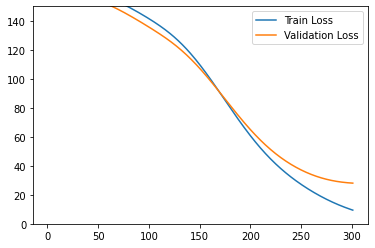

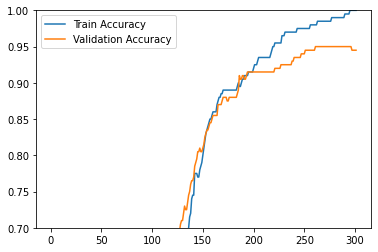

In [8]:
lrmodel_noregr = fit_logregr(mnistbin_train_x,mnistbin_train_y,
                             mnistbin_val_x,mnistbin_val_y,0,quiet=False)

plot_logregr_training(lrmodel_noregr)

**QUESTION 3**

it 0: loss = 183.2, acc = 0.55, ||dloss||^2 = 3.08e+04, step_size = 1e-06
       loss_val = 188.6, acc_val = 0.49
it 10: loss = 182.9, acc = 0.55, ||dloss||^2 = 3.014e+04, step_size = 1.357e-06
       loss_val = 188.3, acc_val = 0.5
it 20: loss = 182.4, acc = 0.54, ||dloss||^2 = 2.927e+04, step_size = 1.842e-06
       loss_val = 187.8, acc_val = 0.51
it 30: loss = 181.8, acc = 0.54, ||dloss||^2 = 2.817e+04, step_size = 2.499e-06
       loss_val = 187.2, acc_val = 0.51
it 40: loss = 181.0, acc = 0.54, ||dloss||^2 = 2.68e+04, step_size = 3.391e-06
       loss_val = 186.4, acc_val = 0.52
it 50: loss = 179.9, acc = 0.53, ||dloss||^2 = 2.515e+04, step_size = 4.602e-06
       loss_val = 185.3, acc_val = 0.52
it 60: loss = 178.6, acc = 0.55, ||dloss||^2 = 2.324e+04, step_size = 6.245e-06
       loss_val = 184.1, acc_val = 0.52
it 70: loss = 176.9, acc = 0.56, ||dloss||^2 = 2.115e+04, step_size = 8.474e-06
       loss_val = 182.5, acc_val = 0.53
it 80: loss = 174.9, acc = 0.57, ||dloss||^2 = 1

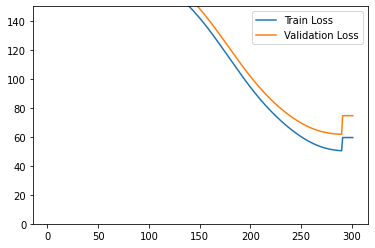

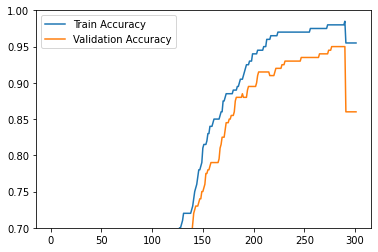

In [9]:
lrmodel_regr = fit_logregr(mnistbin_train_x,mnistbin_train_y,
                           mnistbin_val_x,mnistbin_val_y,10.0,quiet=False)
plot_logregr_training(lrmodel_regr)

## Investigate the models

Visualize the weights of the regularized and unregularized logistic regression model using the `display_mnist_digit` function.

**QUESTION 4**

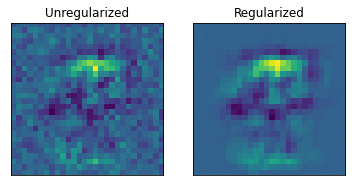

In [10]:
# TODO: show images representing the weights of the two classes
D = mnistbin_train_x.shape[1]
noregr_theta = lrmodel_noregr['theta'][:D]
regr_theta = lrmodel_regr['theta'][:D]

plt.subplot(1,2,1)
display_mnist_digit(noregr_theta,lbl='Unregularized')
plt.subplot(1,2,2)
display_mnist_digit(regr_theta,lbl='Regularized')




Find and visualize some interesting examples from the validation set.

**QUESTION 5** and **QUESTION 6**

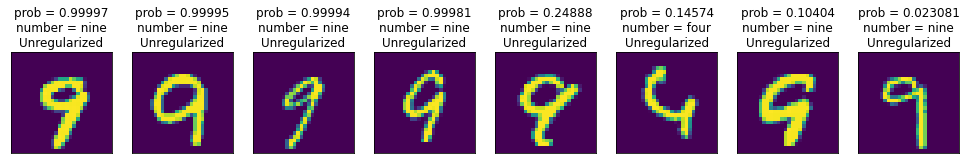

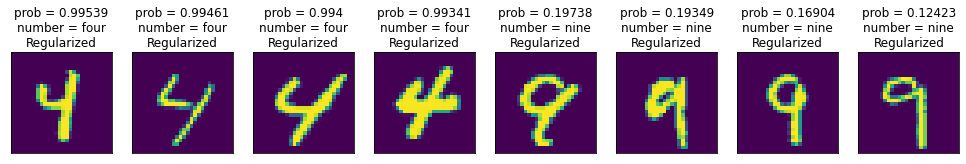

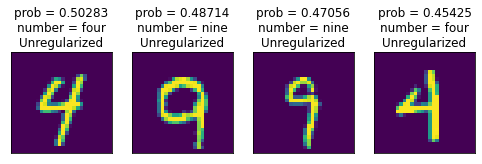

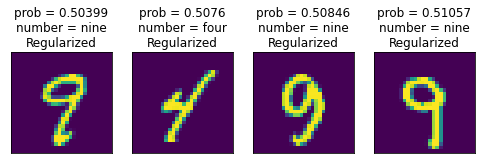

In [11]:
# Evaluate the log probabilities under the model for each class of the
# validation data.
val_noregr_lps = logregr_logprob(mnistbin_val_x,lrmodel_noregr['theta'])
val_regr_lps = logregr_logprob(mnistbin_val_x,lrmodel_regr['theta'])

# TODO: Sort examples in the validation set according to probability of the
# correct class.  Then show the four images with the lowest probability of the
# correct class and the four images with the highest probabilities of the
# correct class.  For each image include in it's title the probability of the
# correct class with and without regularization and which is the correct class,
# 4 or 9.

# val_noregr_correct = val_noregr_lps[:,1]
# val_regr_correct = val_regr_lps[:,1]
val_noregr_correct = mnistbin_val_y*val_noregr_lps[:,1] + (1-mnistbin_val_y)*val_noregr_lps[:,0]
val_regr_correct = mnistbin_val_y*val_regr_lps[:,1] + (1-mnistbin_val_y)*val_regr_lps[:,0]

val_noregr_sorted = sorted(((value,index) for index, value in enumerate(val_noregr_correct)), reverse=True)
val_regr_sorted = sorted(((value,index) for index, value in enumerate(val_regr_correct)), reverse=True)


count = 0
plt.figure(figsize=(17,10))
for (value,index) in val_noregr_sorted[:4]:
  plt.subplot(1,8,count+1)
  display_mnist_digit(mnistbin_train_x[index,:], 
              'prob = {:.5}\nnumber = {}\n{}'.format(np.exp(value), 'nine' if mnistbin_train_y[index] else 'four','Unregularized'))
  count = count+1
for (value,index) in val_noregr_sorted[-4:]:
  plt.subplot(1,8,count+1)
  display_mnist_digit(mnistbin_train_x[index,:], 
              'prob = {:.5}\nnumber = {}\n{}'.format(np.exp(value), 'nine' if mnistbin_train_y[index] else 'four','Unregularized'))
  count = count+1

count = 0
plt.figure(figsize=(17,10))
for (value,index) in val_regr_sorted[:4]:
  plt.subplot(2,8,count+1)
  display_mnist_digit(mnistbin_train_x[index,:], 
              'prob = {:.5}\nnumber = {}\n{}'.format(np.exp(value), 'nine' if mnistbin_train_y[index] else 'four','Regularized'))
  count = count+1
for (value,index) in val_regr_sorted[-4:]:
  plt.subplot(2,8,count+1)
  display_mnist_digit(mnistbin_train_x[index,:], 
              'prob = {:.5}\nnumber = {}\n{}'.format(np.exp(value), 'nine' if mnistbin_train_y[index] else 'four','Regularized'))
  count = count+1


# TODO: Sort examples in the validation set according to the absolute difference
# between the probability of the correct class and 0.5.  Then show the four
# images whose probability of correct class is closest to 0.5.  For each image
# include in it's title the probability of the correct class with and without
# regularization and which is the correct class, 4 or 9.

val_noregr_abs = sorted(((value,index) for index, value in enumerate(np.abs(val_noregr_lps[:,1]-np.log(0.5)))))
val_regr_abs = sorted(((value,index) for index, value in enumerate(np.abs(val_regr_lps[:,1]-np.log(0.5)))))

count = 0
plt.figure(figsize=(17,10))
for (value,index) in val_noregr_abs[:4]:
  plt.subplot(1,8,count+1)
  display_mnist_digit(mnistbin_train_x[index,:], 
              'prob = {:.5}\nnumber = {}\n{}'.format(np.exp(val_noregr_lps[:,1][index]), 'nine' if mnistbin_train_y[index] else 'four','Unregularized'))
  count = count+1

count = 0
plt.figure(figsize=(17,10))
for (value,index) in val_regr_abs[:4]:
  plt.subplot(2,8,count+1)
  display_mnist_digit(mnistbin_train_x[index,:], 
              'prob = {:.5}\nnumber = {}\n{}'.format(np.exp(val_regr_lps[:,1][index]), 'nine' if mnistbin_train_y[index] else 'four','Regularized'))
  count = count+1




# Step 3: Run LR again with a different set of digit classes
This time, use the digits 0 and 1.

**QUESTION 7**

55.0% of the training data is class True, corresponding to 110 data points


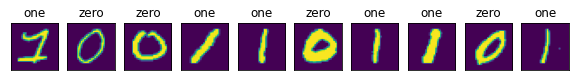

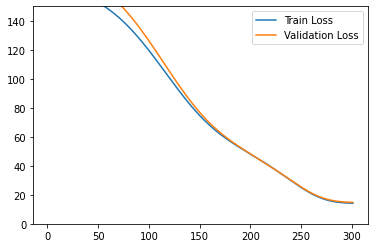

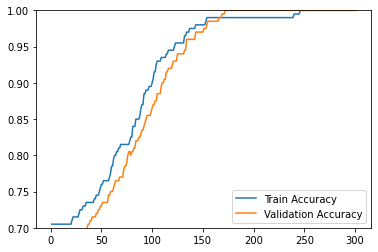

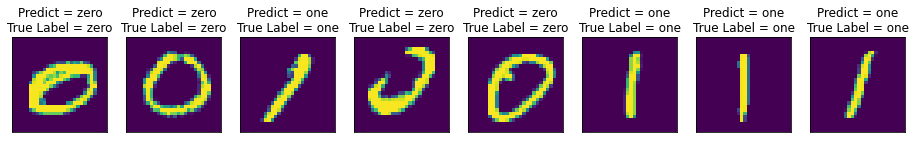

In [12]:
# TODO: Use the `binary_mnist` function to partition the dataset differently and
# follow the same basic steps as above.  First, visualize a few images from the
# new dataset to get a sense.  Then run regularized logistic regression on this
# new dataset, visualize the training and validation performance curves and
# print results.  Finally, visualize a few sample images and their predicted
# class probabilities and true labels.

bin_train_x,bin_train_y,bin_val_x,bin_val_y = binary_mnist(1,0)

# Print statistics
print('{}% of the training data is class True, corresponding to {} data points'.format(100*np.sum(bin_train_y)/len(bin_train_y),np.sum(bin_train_y)))

# Visualize a few random images
np.random.seed(0)
num_digits = 10
plt.figure(figsize=(10,5))
for i in range(num_digits):
  ind = np.random.randint(0,bin_train_x.shape[0])
  plt.subplot(1,num_digits,i+1)
  display_mnist_digit(bin_train_x[ind,:],
                      'one' if bin_train_y[ind] else 'zero')

# Run regularized logistic regression and visualize curves
lrmodel_regr = fit_logregr(bin_train_x,bin_train_y,
                           bin_val_x,bin_val_y,10.0,quiet=True)
plot_logregr_training(lrmodel_regr)

# Visualize a few sample images and their predicted class probabilities
val_regr_lps = logregr_logprob(bin_val_x,lrmodel_regr['theta'])
num_digits = 8
plt.figure(figsize=(16,10))
for i in range(num_digits):
  ind = np.random.randint(0,bin_val_x.shape[0])
  plt.subplot(1,num_digits,i+1)
  gt = bin_val_y[ind] + 0
  prediction = 'one' if (val_regr_lps[:,1][ind] > np.log(0.5)) else 'zero'
  display_mnist_digit(bin_val_x[ind,:],
                      'Predict = {}\nTrue Label = {}'.format(prediction,'one' if bin_val_y[ind] else 'zero'))

